# Stock Prediction using CNN

**Prerequisite**
```!pip install pandas_datareader --user```

In [11]:
import sys
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like

from pandas_datareader import data as pdr
from tqdm import tqdm,trange

In [12]:
stock_list = ['KBANK','SCB','BBL','KTB','AOT','BEAUTY']

In [17]:
stock_data = []
stock_name = []
for quote in tqdm(stock_list):
    try:
        stock_data.append(pdr.get_data_yahoo('{}.BK'.format(quote), start='2010-01-01', end='2018-11-30'))
        stock_name.append(quote)
    except:
        print("Error:", sys.exc_info()[0])
        print("Description:", sys.exc_info()[1])

100%|██████████| 6/6 [00:00<00:00, 2650.43it/s]

Error: <class 'pandas_datareader.exceptions.ImmediateDeprecationError'>
Description: 
Yahoo Actions has been immediately deprecated due to large breaks in the API without the
introduction of a stable replacement. Pull Requests to re-enable these data
connectors are welcome.

See https://github.com/pydata/pandas-datareader/issues

Error: <class 'pandas_datareader.exceptions.ImmediateDeprecationError'>
Description: 
Yahoo Actions has been immediately deprecated due to large breaks in the API without the
introduction of a stable replacement. Pull Requests to re-enable these data
connectors are welcome.

See https://github.com/pydata/pandas-datareader/issues

Error: <class 'pandas_datareader.exceptions.ImmediateDeprecationError'>
Description: 
Yahoo Actions has been immediately deprecated due to large breaks in the API without the
introduction of a stable replacement. Pull Requests to re-enable these data
connectors are welcome.

See https://github.com/pydata/pandas-datareader/issues

Erro

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

Using TensorFlow backend.


In [0]:
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = Y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test
  
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [11]:
data_original = stock_data[-1]

openp = data_original.ix[:, 'Open'].tolist()
highp = data_original.ix[:, 'High'].tolist()
lowp = data_original.ix[:, 'Low'].tolist()
closep = data_original.ix[:, 'Adj Close'].tolist()
volumep = data_original.ix[:, 'Volume'].tolist()

# data_chng = data_original.ix[:, 'Adj Close'].pct_change().dropna().tolist()

WINDOW = 10
EMB_SIZE = 5
STEP = 1
FORECAST = 1

X, Y = [], []
for i in range(0, len(data_original), STEP): 
    try:
        o = openp[i:i+WINDOW]
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volumep[i:i+WINDOW]

        o = (np.array(o) - np.mean(o)) / np.std(o)
        h = (np.array(h) - np.mean(h)) / np.std(h)
        l = (np.array(l) - np.mean(l)) / np.std(l)
        c = (np.array(c) - np.mean(c)) / np.std(c)
        v = (np.array(v) - np.mean(v)) / np.std(v)

#         x_i = closep[i:i+WINDOW]
        y_i = closep[i+WINDOW+FORECAST]  

#         next_close = y_i

#         if last_close < next_close:
#             y_i = [1, 0]
#         else:
#             y_i = [0, 1] 

        x_i = np.column_stack((o, h, l, c, v))

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))


model = Sequential()
model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                        nb_filter=16,
                        filter_length=4,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(nb_filter=8,
                        filter_length=4,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())


model.add(Dense(1))
# model.add(Activation('softmax'))

opt = Nadam(lr=0.002)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
# checkpointer = ModelCheckpoint(filepath="lolkek.hdf5", verbose=1, save_best_only=True)


model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

model.fit(X_train,Y_train,epochs=150,verbose=1)
pred = model.predict(np.array(X_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(10, 5), filters=16, kernel_size=4, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=8, kernel_size=4, padding="same")`


Epoch 1/150
1304/1304 [==============================] - 2s 1ms/step - loss: 72.4465 - mean_squared_error: 72.4465
Epoch 2/150
1304/1304 [==============================] - 1s 516us/step - loss: 53.3175 - mean_squared_error: 53.3175
Epoch 3/150
1304/1304 [==============================] - 1s 504us/step - loss: 42.2464 - mean_squared_error: 42.2464
Epoch 4/150
1304/1304 [==============================] - 1s 519us/step - loss: 37.7881 - mean_squared_error: 37.7881
Epoch 5/150
1304/1304 [==============================] - 1s 517us/step - loss: 36.3184 - mean_squared_error: 36.3184
Epoch 6/150
1304/1304 [==============================] - 1s 511us/step - loss: 35.4429 - mean_squared_error: 35.4429
Epoch 7/150
1304/1304 [==============================] - 1s 511us/step - loss: 35.5525 - mean_squared_error: 35.5525
Epoch 8/150
1304/1304 [==============================] - 1s 510us/step - loss: 35.4173 - mean_squared_error: 35.4173
Epoch 9/150
1304/1304 [==============================] - 1s 503us/

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

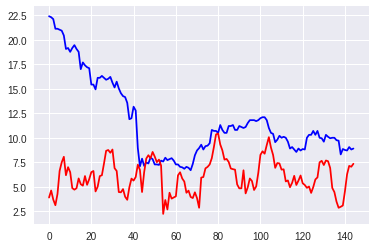

In [12]:
plt.plot(Y_test,'b')
plt.plot(pred,'r')

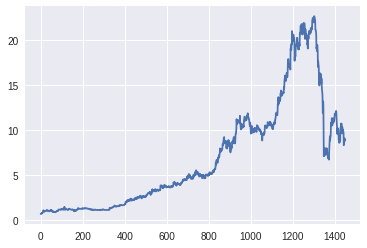

In [13]:
plt.plot(Y)